In [43]:
import os
import sys
import PATH
import numpy as np
import pandas as pd
import utils
import logging
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

from models import CNN_models
from models.popen import Auto_popen
from models import reader
from models import log_and_save
from models import ScheduleOptimizer

In [55]:
from importlib import reload
reload(CNN_models)

<module 'models.CNN_models' from '/home/wergillius/Project/UTR_VAE/models/CNN_models.py'>

## read A549 data first

In [229]:
batch_size = 50
dataset = reader.UTR_dataset(cell_line='293T')
A549_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=8)

# latent dim =2

## read model

In [165]:
# init
model = CNN_models.Conv_VAE(*popen.model_args).cuda()
ScheduledOptim = ScheduleOptimizer.ScheduledOptim
optimizer = eval(ScheduleOptimizer.scheduleoptim_text)
logger = logging.getLogger("VAE")

In [56]:
popen = Auto_popen("/home/wergillius/Project/UTR_VAE/log/Conv_VAE_mix/setting3/latent_dim_2.ini")

In [231]:
embedding_ls = []
Y_ls = []

In [171]:
utils.resume(popen,model,optimizer,logger)

## embed

In [232]:
A549_iter = iter(A549_loader)

In [233]:
for X,Y in A549_iter:
    zeros_side = torch.zeros((X.shape[0],X.shape[1],1))
    X_5dim = torch.cat([X,zeros_side],dim=2).float().cuda()
    Y_ls.append(Y.numpy())
    with torch.no_grad():
        embedding_ls.append(model.embed(X_5dim))

In [234]:
embedding_ls = torch.cat(embedding_ls)

In [235]:
Y_ls = np.concatenate(Y_ls)

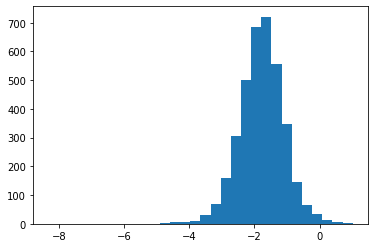

In [236]:
plt.hist(np.log(Y_ls),bins=30);

In [237]:
embedding_ls = embedding_ls.cpu().numpy()

In [238]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

In [244]:
high_score = np.log(Y_ls) > 0
low_score = np.log(Y_ls) <= -3

norm = colors.Normalize(vmin=-5,vmax=np.log(Y_ls).max())
#norm = colors.Normalize(vmin=np.log(Y_ls).min(),vmax=np.log(Y_ls).max())

scat=cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

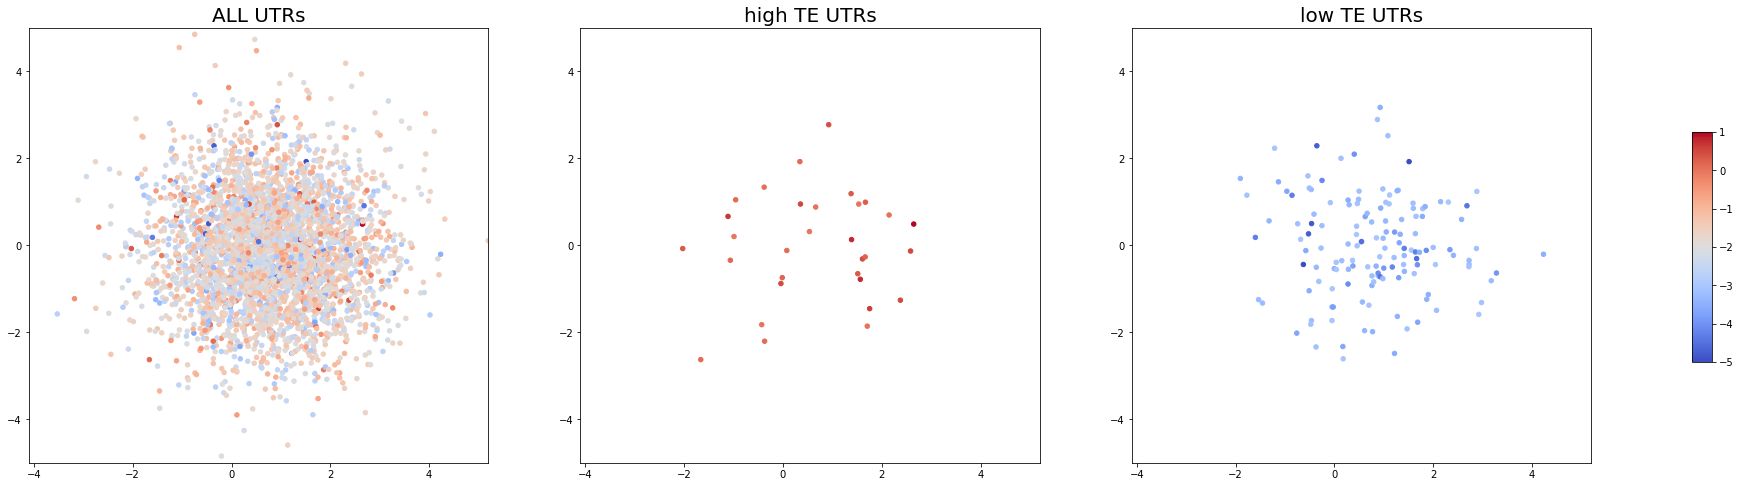

In [245]:
fig = plt.figure(figsize=(28,8))

ax = plt.subplot(1,3,1)
ax.scatter(embedding_ls[:,0],embedding_ls[:,1],s=20,c=np.log(Y_ls),cmap=cm.coolwarm,norm=norm)
ax.set_xlim(-4.1,5.2)
ax.set_ylim(-5,5)
ax.set_title("ALL UTRs",fontsize=20)

ax = plt.subplot(1,3,2)
ax.scatter(embedding_ls[high_score,0],embedding_ls[high_score,1],s=20,c=np.log(Y_ls)[high_score],cmap=cm.coolwarm,norm=norm)
ax.set_xlim(-4.1,5.2)
ax.set_ylim(-5,5)
ax.set_title("high TE UTRs",fontsize=20)

ax = plt.subplot(1,3,3)
ax.scatter(embedding_ls[low_score,0],embedding_ls[low_score,1],s=20,c=np.log(Y_ls)[low_score],cmap=cm.coolwarm,norm=norm)
ax.set_xlim(-4.1,5.2)
ax.set_ylim(-5,5)
ax.set_title("low TE UTRs",fontsize=20)

ax_color = fig.add_axes([0.95,0.3,0.01,0.4])
fig.colorbar(scat,cax=ax_color)

In [256]:
rrange = (embedding_ls[high_score,1] <-0.2)&((embedding_ls[high_score,1] >-2))&(embedding_ls[high_score,0] <0.1 ) &( embedding_ls[high_score,0] >-0.1)

In [257]:
rrange

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False])

In [263]:
new_embed = np.mean(embedding_ls[high_score][rrange],axis=0)

In [265]:
code = torch.tensor(new_embed).float().cuda()

In [270]:
re_code = model.fc_decode(code)
re_code = re_code.view(1,model.channel_ls[-1],model.out_length)
out = model.decode(re_code)

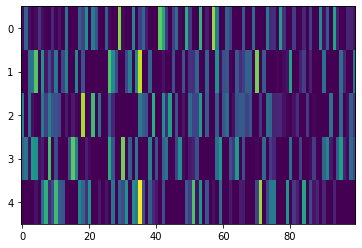

In [281]:
plt.imshow(out.squeeze().detach().cpu().numpy(),aspect="auto")